# IMPORT LIBRARIES

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import seaborn as sns
import cv2
import hashlib
import shutil
from PIL import Image
from bs4 import BeautifulSoup
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
sns.set(style='darkgrid',color_codes=True)
#from tensorflow.keras.applications import VGG16, RESNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input


import warnings

warnings.filterwarnings("ignore")

# DATA SCRAPE & COLLECTION 

In [4]:
classes = {
    "acne": "https://dermnetnz.org/topics/acne",
    "eczema": "https://dermnetnz.org/topics/atopic-dermatitis",
    "hyperpigmentation": "https://dermnetnz.org/topics/melasma",
    "rash": "https://dermnetnz.org/topics/skin-rash",
    "healthy": "https://dermnetnz.org/topics/normal-skin"
}

base_dir = "dermnet_dataset"
os.makedirs(base_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

In [13]:
def deep_scrape(topic_url, folder):
    html = requests.get(topic_url).text
    soup = BeautifulSoup(html, "html.parser")

    links = soup.find_all("a")

    count = 0

    # scrape main page
    count = scrape_one_page(topic_url, folder, count)

    # scrape subpages
    for link in links:
        href = link.get("href")
        if not href:
            continue

        if href.startswith("/topics/"):
            sub_url = "https://dermnetnz.org" + href
            count = scrape_one_page(sub_url, folder, count)

    print("Downloaded:", count, "images")



In [15]:
for label, url in classes.items():
    print("\nScraping:", label)
    folder = os.path.join(base_dir, label)
    deep_scrape(url, folder)


Scraping: acne
Downloaded: 1625 images

Scraping: eczema
Downloaded: 2288 images

Scraping: hyperpigmentation
Downloaded: 1310 images

Scraping: rash
Downloaded: 319 images

Scraping: healthy
Downloaded: 319 images


# DATA CLEANING & PRE-PROCESSING

In [17]:
dataset_dir = "dermnet_dataset"   # change if your folder has another name

bad_images = 0

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        path = os.path.join(root, file)

        try:
            img = Image.open(path)
            img.verify()            # checks if the image is broken
        except Exception as e:
            print("Removing bad image:", path)
            os.remove(path)
            bad_images += 1

print("Done!")
print("Total removed corrupted/empty images:", bad_images)


Removing bad image: dermnet_dataset\acne\1014.jpg
Removing bad image: dermnet_dataset\acne\1028.jpg
Removing bad image: dermnet_dataset\acne\1042.jpg
Removing bad image: dermnet_dataset\acne\1057.jpg
Removing bad image: dermnet_dataset\acne\1078.jpg
Removing bad image: dermnet_dataset\acne\1094.jpg
Removing bad image: dermnet_dataset\acne\1108.jpg
Removing bad image: dermnet_dataset\acne\1128.jpg
Removing bad image: dermnet_dataset\acne\1142.jpg
Removing bad image: dermnet_dataset\acne\1156.jpg
Removing bad image: dermnet_dataset\acne\1170.jpg
Removing bad image: dermnet_dataset\acne\1187.jpg
Removing bad image: dermnet_dataset\acne\1206.jpg
Removing bad image: dermnet_dataset\acne\1220.jpg
Removing bad image: dermnet_dataset\acne\1239.jpg
Removing bad image: dermnet_dataset\acne\1258.jpg
Removing bad image: dermnet_dataset\acne\1272.jpg
Removing bad image: dermnet_dataset\acne\1606.jpg
Removing bad image: dermnet_dataset\acne\242.jpg
Removing bad image: dermnet_dataset\acne\265.jpg
Re

In [21]:
dataset_dir = "dermnet_dataset"

hashes = set()
duplicate_count = 0

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        path = os.path.join(root, file)

        with open(path, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()

        if filehash in hashes:
            print("Removing duplicate:", path)
            os.remove(path)
            duplicate_count += 1
        else:
            hashes.add(filehash)

print("Done!")
print("Total removed duplicates:", duplicate_count)

Removing duplicate: dermnet_dataset\acne\1141.jpg
Removing duplicate: dermnet_dataset\acne\1155.jpg
Removing duplicate: dermnet_dataset\acne\1169.jpg
Removing duplicate: dermnet_dataset\acne\1186.jpg
Removing duplicate: dermnet_dataset\acne\1205.jpg
Removing duplicate: dermnet_dataset\acne\1219.jpg
Removing duplicate: dermnet_dataset\acne\1226.jpg
Removing duplicate: dermnet_dataset\acne\1227.jpg
Removing duplicate: dermnet_dataset\acne\1228.jpg
Removing duplicate: dermnet_dataset\acne\1229.jpg
Removing duplicate: dermnet_dataset\acne\1230.jpg
Removing duplicate: dermnet_dataset\acne\1238.jpg
Removing duplicate: dermnet_dataset\acne\1245.jpg
Removing duplicate: dermnet_dataset\acne\1246.jpg
Removing duplicate: dermnet_dataset\acne\1247.jpg
Removing duplicate: dermnet_dataset\acne\1248.jpg
Removing duplicate: dermnet_dataset\acne\1249.jpg
Removing duplicate: dermnet_dataset\acne\1257.jpg
Removing duplicate: dermnet_dataset\acne\1271.jpg
Removing duplicate: dermnet_dataset\acne\1303.jpg


In [3]:
dermnet =r"C:\Users\USER\Desktop\Desktop\dermnet_dataset"
skinset = r"C:\Users\USER\Desktop\Desktop\skin_diseases_dataset"

# output folder
merged = r"C:\Users\USER\Desktop\Desktop\skin_dataset"

# create merged folders
os.makedirs(os.path.join(merged, "acne"), exist_ok=True)
os.makedirs(os.path.join(merged, "hyperpigmentation"), exist_ok=True)
os.makedirs(os.path.join(merged, "eczema"), exist_ok=True)
os.makedirs(os.path.join(merged, "Vitiligo"), exist_ok=True)

# -------- helper function --------
def copy_all(src_folder, dest_folder):
    if not os.path.exists(src_folder):
        return
    for file in os.listdir(src_folder):
        src_path = os.path.join(src_folder, file)
        dst_path = os.path.join(dest_folder, file)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

# -------- merge acne --------
copy_all(os.path.join(dermnet, "acne"),
         os.path.join(merged, "acne"))

copy_all(os.path.join(skinset, "acne"),
         os.path.join(merged, "acne"))

# -------- merge hyperpigmentation --------
copy_all(os.path.join(dermnet, "hyperpigmentation"),
         os.path.join(merged, "hyperpigmentation"))

copy_all(os.path.join(skinset, "hyperpigmentation"),
         os.path.join(merged, "hyperpigmentation"))

# -------- eczema only from DermNet --------
copy_all(os.path.join(dermnet, "eczema"),
         os.path.join(merged, "eczema"))

# -------- vitiligo only from SkinDataset --------
copy_all(os.path.join(skinset, "Vitiligo"),
         os.path.join(merged, "Vitiligo"))

print("Merging done.")

Merging done.


In [3]:
dataset_dir = "skin_dataset"

hashes = set()
duplicate_count = 0

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        path = os.path.join(root, file)

        with open(path, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()

        if filehash in hashes:
            print("Removing duplicate:", path)
            os.remove(path)
            duplicate_count += 1
        else:
            hashes.add(filehash)

print("Done!")
print("Total removed duplicates:", duplicate_count)

Removing duplicate: skin_dataset\acne\Crop-100450_100400141__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
Removing duplicate: skin_dataset\acne\Crop-100450_100400142__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
Removing duplicate: skin_dataset\acne\Crop-100450_100400143__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
Removing duplicate: skin_dataset\acne\Crop-100450_100400144__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
Removing duplicate: skin_dataset\acne\Crop-100450_100400146__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDEwXQ.jpg
Removing duplicate: skin_dataset\acne\Crop-100450_100400148__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
Removing duplicate: skin_dataset\acne\Crop-100450_100400149__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
Removing duplicate: skin_dataset\acne\Crop-100450_100400150__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
Removing duplicate: skin_dataset\acne\Crop-100450_1004

In [3]:
data_path= r'C:\Users\USER\Desktop\Desktop\skin_dataset'

images=[]
labels=[]

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path,subfolder)
    if not os.path.isdir(subfolder_path):
          continue

    for image_filename in os.listdir(subfolder_path):
        image_path=os.path.join(subfolder_path,image_filename)
        images.append(image_path)

        labels.append(subfolder)

df=pd.DataFrame({'image' : images, 'label': labels})

In [ ]:
base_path = "dataset"   # change this to your dataset folder

for class_name in os.listdir(base_path):
    class_folder = os.path.join(base_path, class_name)

    if not os.path.isdir(class_folder):
        continue

    # Rename class folder meaning
    if class_name == "O":
        new_class_name = "organic"
    elif class_name == "R":
        new_class_name = "recycle"
    else:
        new_class_name = class_name

    new_class_folder = os.path.join(base_path, new_class_name)
    os.rename(class_folder, new_class_folder)

    files = os.listdir(new_class_folder)

    for i, filename in enumerate(files, start=1):
        old_path = os.path.join(new_class_folder, filename)
        ext = os.path.splitext(filename)[1]

        new_name = f"{new_class_name}({i}){ext}"
        new_path = os.path.join(new_class_folder, new_name)

        os.rename(old_path, new_path)

print("Renaming complete!")

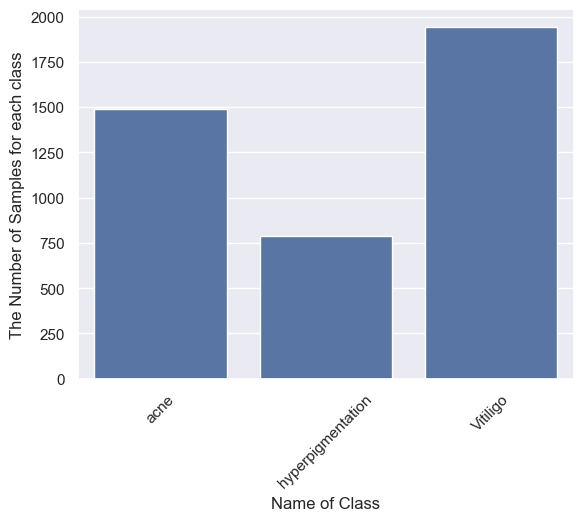

In [5]:
ax = sns.countplot(x=df.label)
ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number of Samples for each class")
plt.xticks(rotation=45)
plt.show()

In [7]:
base_path = "skin_dataset"

images = []
labels = []

for class_name in os.listdir(base_path):
    class_folder = os.path.join(base_path, class_name)
    if not os.path.isdir(class_folder):
        continue

    for filename in os.listdir(class_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            images.append(os.path.join(class_folder, filename))
            labels.append(class_name)

df = pd.DataFrame({'image': images, 'label': labels})

print("Total images:", len(df))
print("Classes:", df['label'].unique())

Total images: 4219
Classes: ['acne' 'hyperpigmentation' 'Vitiligo']


# DATA MODELING

In [9]:
X_train, X_test,y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)
df_train=pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test= encoder.transform(y_test)


In [11]:
df.head(5)

,image,label
0,skin_dataset\acne\acne(1).jpg,acne
1,skin_dataset\acne\acne(10).jpg,acne
2,skin_dataset\acne\acne(100).jpg,acne
3,skin_dataset\acne\acne(1000).jpg,acne
4,skin_dataset\acne\acne(1001).jpg,acne


In [13]:
image_size=(50, 50)
batch_size=32

train_datagen= ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size= image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    df_test, 
    x_col='image',
    y_col='label',
    target_size= image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3375 validated image filenames belonging to 3 classes.
Found 844 validated image filenames belonging to 3 classes.


In [16]:
input_shape=(50,50,3)

model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(3, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [20]:
history = model.fit(train_generator,epochs=100, validation_data=test_generator) 

Epoch 1/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.4905 - loss: 0.9953 - val_accuracy: 0.4941 - val_loss: 0.9912
Epoch 2/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.5646 - loss: 0.8910 - val_accuracy: 0.5569 - val_loss: 0.8824
Epoch 3/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.5932 - loss: 0.8596 - val_accuracy: 0.6635 - val_loss: 0.7727
Epoch 4/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6556 - loss: 0.7889 - val_accuracy: 0.6777 - val_loss: 0.7368
Epoch 5/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6724 - loss: 0.7661 - val_accuracy: 0.6991 - val_loss: 0.7028
Epoch 6/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6750 - loss: 0.7468 - val_accuracy: 0.6718 - val_loss: 0.7924
Epoch 7/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7009 - loss: 0.7029 - val_accuracy: 0.7287 - val_loss: 0.6369
Epoch 8/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7275 - loss:

# MODEL PERFORMANCE & METRICS

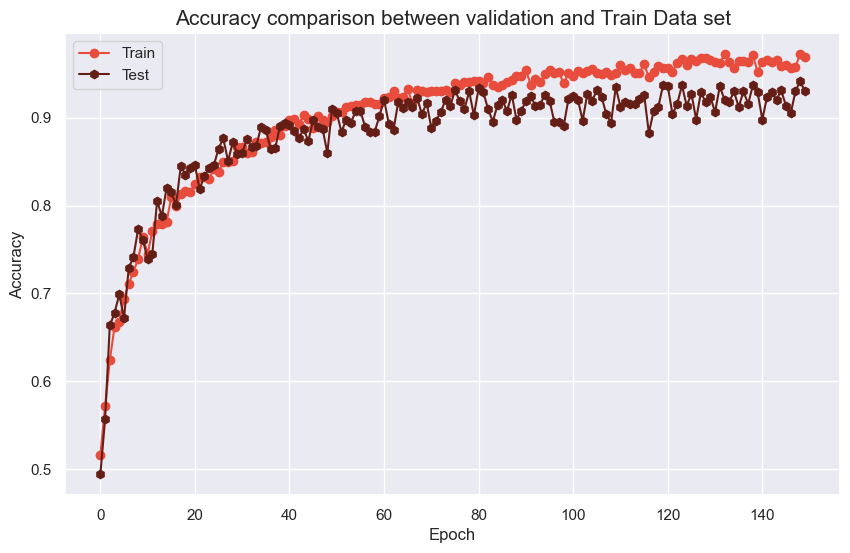

In [22]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], color='#E74C3C', marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16',marker='h')
plt.title('Accuracy comparison between validation and Train Data set', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

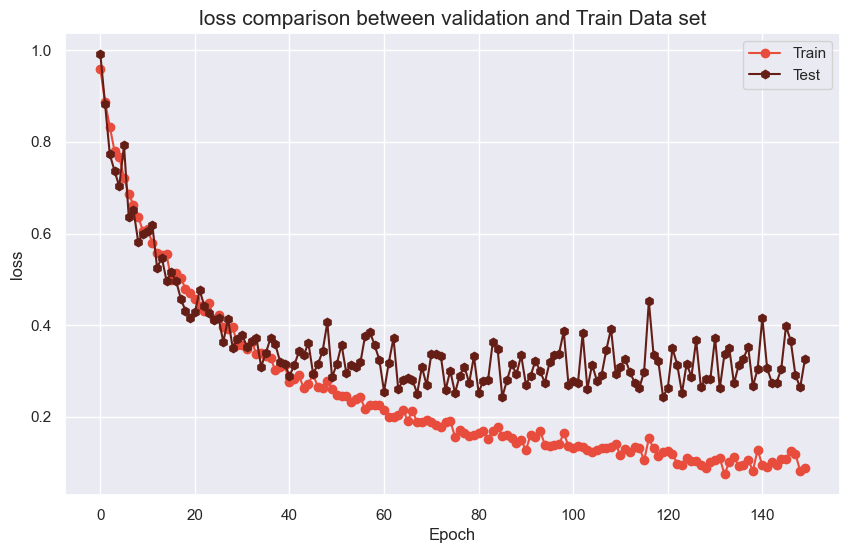

In [24]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='#E74C3C', marker='o')
plt.plot(history.history['val_loss'], color='#641E16',marker='h')
plt.title('loss comparison between validation and Train Data set', fontsize=15)
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [26]:
y_pred_prob = model.predict(test_generator)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


In [28]:
y_pred = np.argmax(y_pred_prob, axis=1)

In [30]:
y_true = test_generator.classes

In [32]:
class_labels = list(test_generator.class_indices.keys())

In [34]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[353  12   9]
 [  8 307  11]
 [  6  13 125]]


In [36]:
print(classification_report(y_true,y_pred, target_names=class_labels))

                   precision    recall  f1-score   support

         Vitiligo       0.96      0.94      0.95       374
             acne       0.92      0.94      0.93       326
hyperpigmentation       0.86      0.87      0.87       144

         accuracy                           0.93       844
        macro avg       0.92      0.92      0.92       844
     weighted avg       0.93      0.93      0.93       844



In [40]:
model.save("skin_modell.h5")

# MODEL DEPLOYMENT

In [1]:
from tensorflow.keras.models import load_model
model = load_model("skin_modell.h5")

In [5]:
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Load model
model = load_model("skin_modell.h5")

# Updated class labels
class_names = ["vitiligo", "acne", "hyperpigmentation"]

st.set_page_config(page_title="Skin Disease Classifier", layout="centered")

st.title("🧴 Skin Condition Classification App")
st.write("Upload a skin image and the model will predict the condition.")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess image
    img = image.resize((50, 50))  # adjust to your model input size if different
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    st.markdown("### 🔍 Prediction Result")
    st.success(f"**{predicted_class.capitalize()}**")
    st.write(f"Confidence: **{confidence:.2f}%**")

2026-01-28 11:39:25.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-28 11:39:25.796 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-28 11:39:25.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-28 11:39:25.800 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-28 11:39:25.802 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-28 11:39:25.804 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-28 11:39:25.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-28 11:39:25.810 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [9]:
import os
# Create the folder
os.makedirs("skin_app", exist_ok=True)

# Create empty app.py file
open("skin_app/app.py", "w").close()

print("skin_app folder and app.py file created successfully!")


skin_app folder and app.py file created successfully!
